In [1]:
def match_barcodes_to_grid(tissue_positions, grid_size, scale_factor, labels, grids, 
                           selected_grid_coords=None, selected_clusters=None):
    """
    Match each barcode to the corresponding grid and associate with a cluster label.
    Optionally, filter by grid coordinates and/or clusters.
    
    Args:
    - tissue_positions: DataFrame with barcode positions.
    - grid_size: Size of the grid in pixels.
    - scale_factor: Factor to scale the full-resolution coordinates.
    - labels: Cluster labels for the grids.
    - grids: List of grid data.
    - selected_grid_coords: List of grid coordinates (tuple) to filter by (optional).
    - selected_clusters: List of clusters to filter by (optional).
    
    Returns:
    - List of (barcode, grid_coords, cluster_label) tuples.
    """
    barcode_to_grid_cluster = []

    for index, row in tissue_positions.iterrows():
        barcode = row['barcode']
        # Scale the full resolution coordinates to the grid resolution
        pxl_row = row['pxl_row_in_fullres'] * scale_factor
        pxl_col = row['pxl_col_in_fullres'] * scale_factor
        
        # Find the corresponding grid based on scaled pixel coordinates
        grid_row = int(pxl_row // grid_size)
        grid_col = int(pxl_col // grid_size)
        
        # Find the grid in the grids list and get the corresponding cluster label
        grid_index = grid_row * ((grids[0][0].shape[1] + grid_size - 1) // grid_size) + grid_col
        cluster_label = labels[grid_index]
        
        # Filter by specific grids if provided
        if selected_grid_coords:
            if (grid_row, grid_col) not in selected_grid_coords:
                continue
        
        # Filter by specific clusters if provided
        if selected_clusters:
            if cluster_label not in selected_clusters:
                continue
        
        barcode_to_grid_cluster.append((barcode, (grid_row, grid_col), cluster_label))

    return barcode_to_grid_cluster

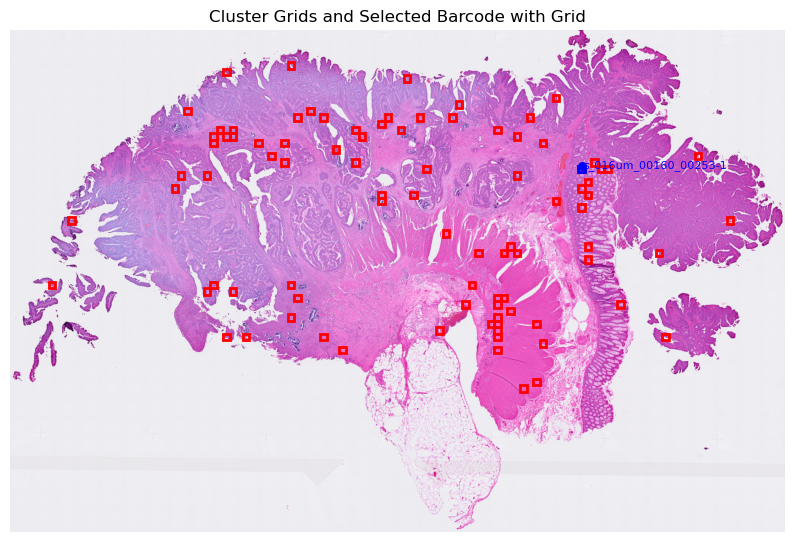

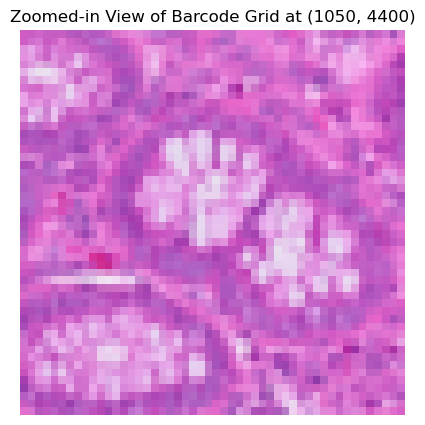

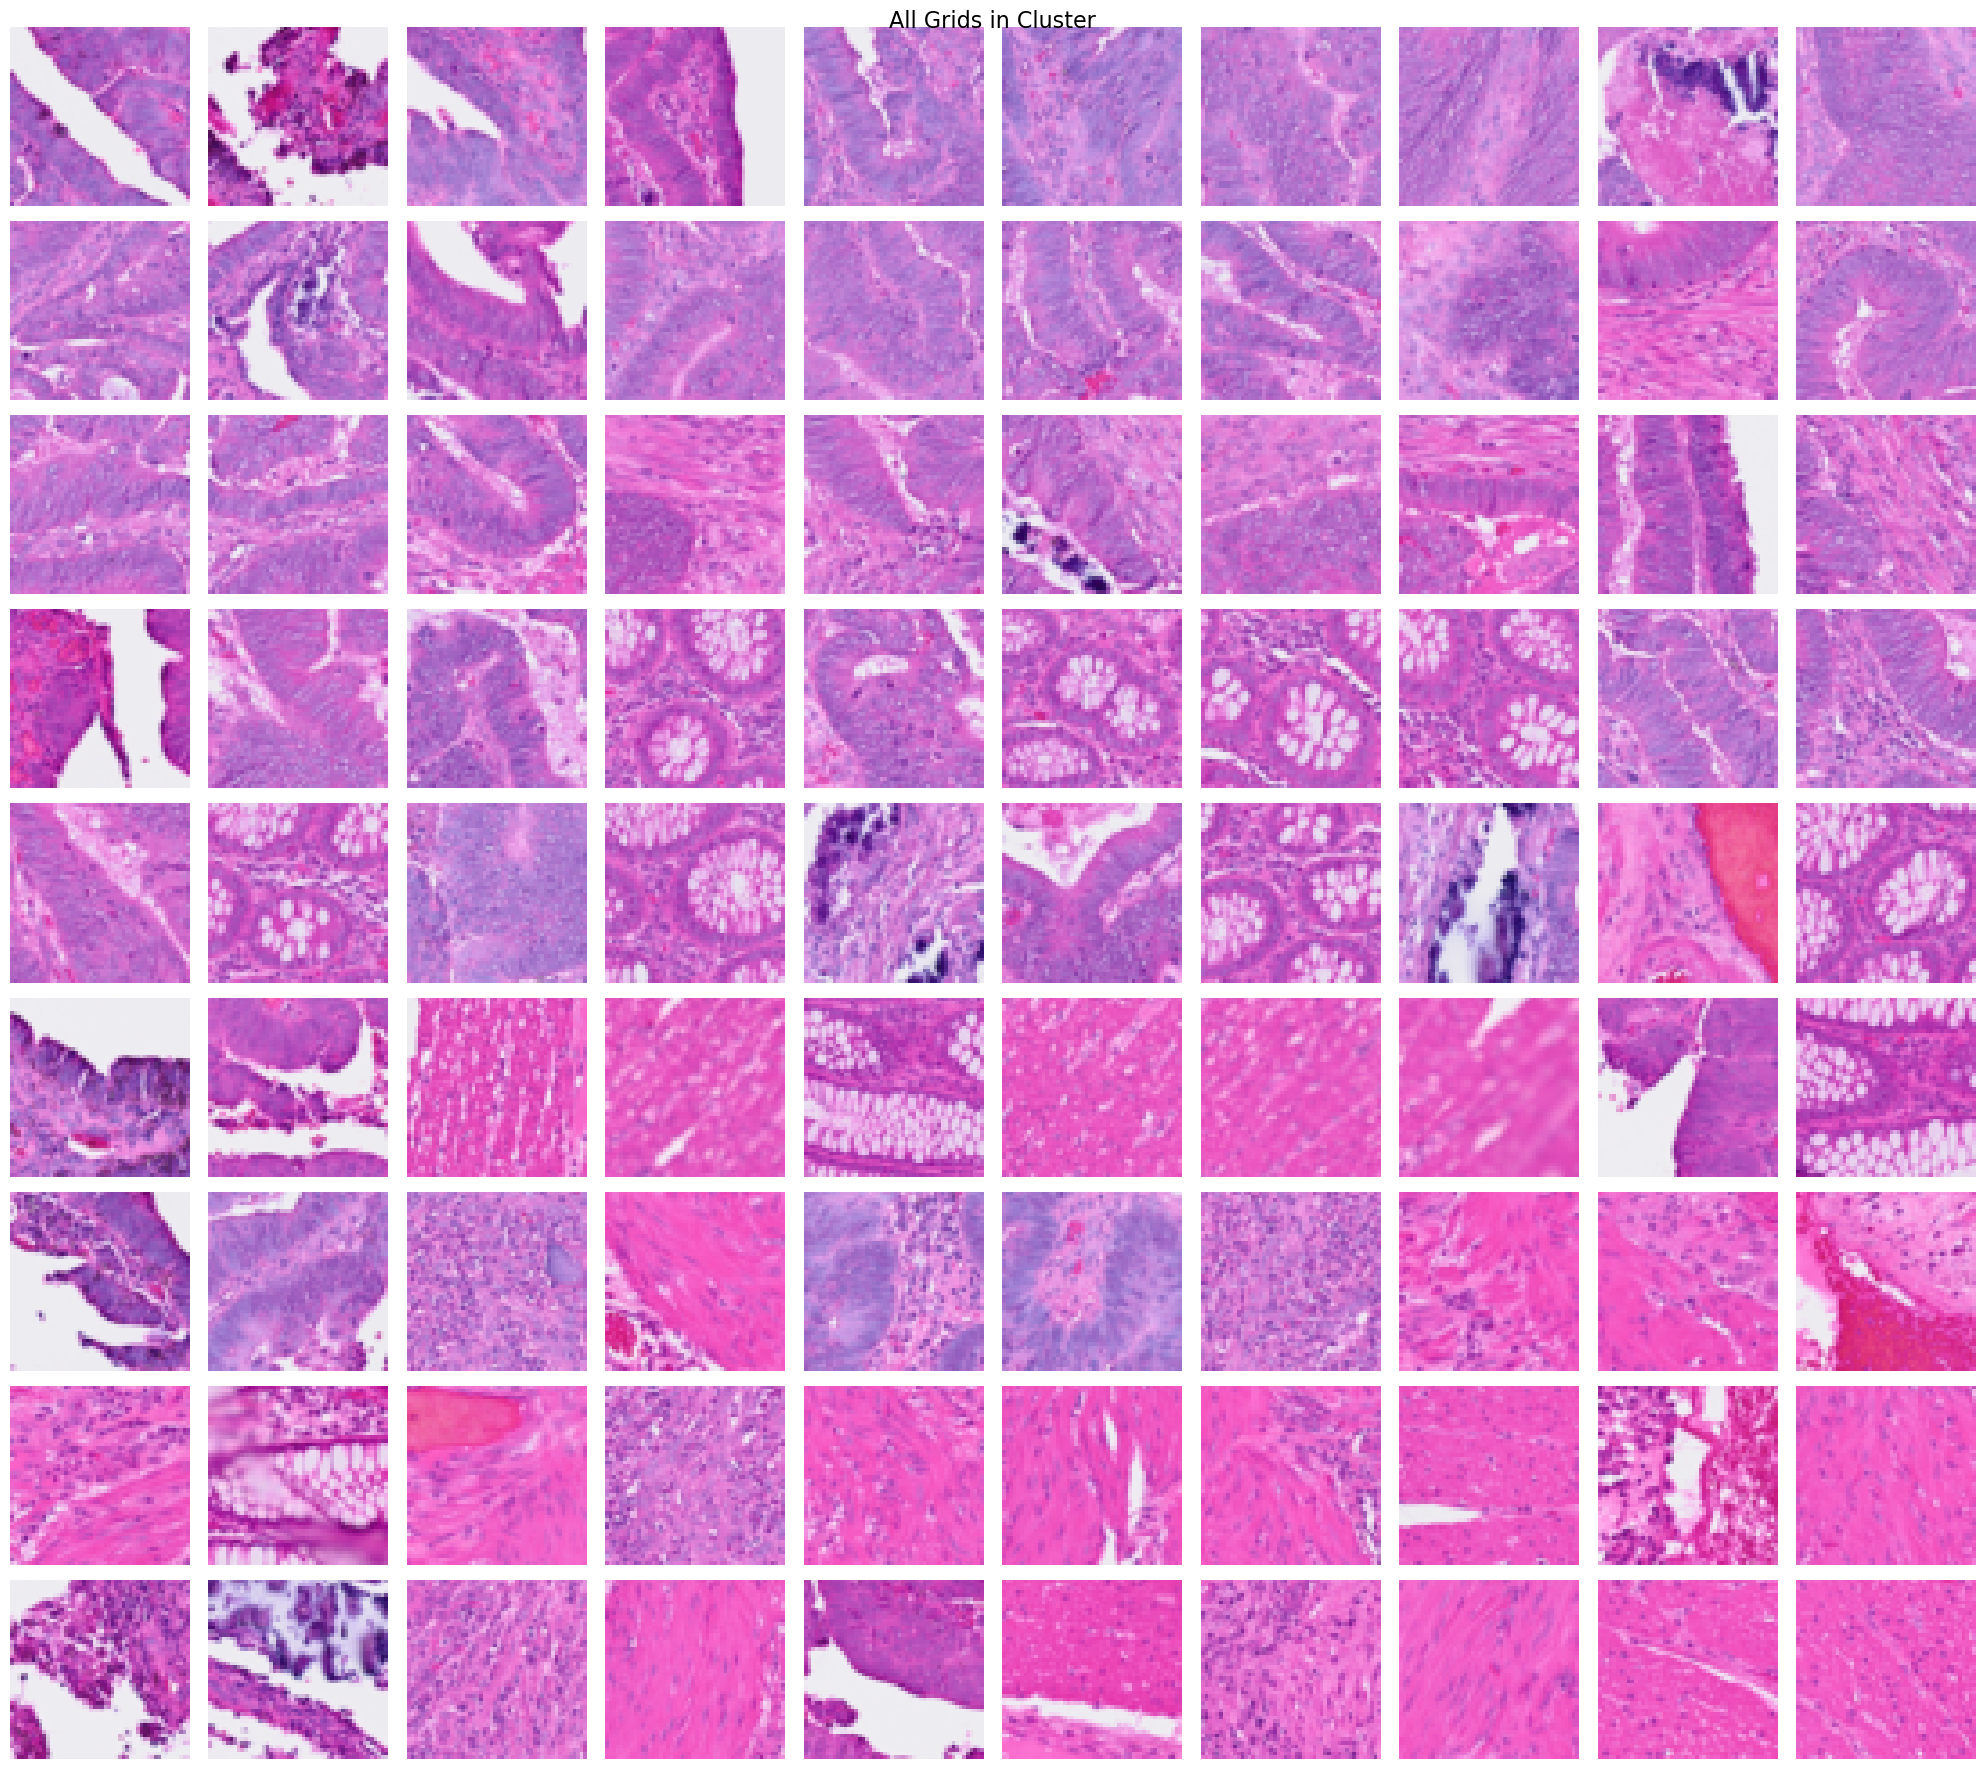

In [6]:
import json
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import math
import cudf
import cupy as cp
import pandas as pd
from cuml.cluster import KMeans
import random

# Function to load the TIF image
def load_tif_image(file_path):
    """Load a TIF image and return a NumPy array."""
    with tiff.TiffFile(file_path) as tif:
        image = tif.asarray()
    return image

# Function to classify grids using RAPIDS (cuML)
def classify_grids_with_rapids(grids, num_clusters=10, background_threshold=240):
    """Use RAPIDS to classify grids into categories based on their mean pixel values."""
    # Extract mean pixel values
    mean_pixel_values = cp.array([grid[1] for grid in grids])
    
    # Use KMeans clustering for classification
    kmeans = KMeans(n_clusters=num_clusters)
    labels = kmeans.fit_predict(mean_pixel_values.reshape(-1, 1))
    
    # Reclassify grids with mean pixel values above the background threshold as a background cluster
    labels = cp.where(mean_pixel_values > background_threshold, num_clusters, labels)
    
    # Convert to numpy array for further processing
    labels = cp.asnumpy(labels)
    
    return labels

# Function to split the image into grids
def split_into_grids(image, grid_size):
    """Split the image into grids of specified size and return a list of grids with pixel data and coordinates."""
    num_rows = (image.shape[0] + grid_size - 1) // grid_size
    num_cols = (image.shape[1] + grid_size - 1) // grid_size
    grids = []
    for i in range(num_rows):
        for j in range(num_cols):
            start_row = i * grid_size
            end_row = min(start_row + grid_size, image.shape[0])
            start_col = j * grid_size
            end_col = min(start_col + grid_size, image.shape[1])
            grid = image[start_row:end_row, start_col:end_col]
            mean_pixel_value = np.mean(grid)
            grids.append((grid, mean_pixel_value, (start_row, start_col)))
    return grids

# Function to mark the grids and barcodes on the original image
def mark_cluster_on_image(image, cluster_grids_coords, grid_size, barcode_coords=None):
    """Mark all grids from the specified cluster on the large image and optionally show barcode positions."""
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    
    # Mark the grids in the cluster (as red)
    for _, coords in cluster_grids_coords:
        start_row, start_col = coords
        rect = plt.Rectangle((start_col, start_row), grid_size, grid_size, edgecolor='red', facecolor='none', lw=2)
        plt.gca().add_patch(rect)
    
    # Mark the barcode position and its grid (as blue)
    if barcode_coords:
        barcode, row, col, grid_coords = barcode_coords
        # Draw the grid for the barcode
        grid_start_row, grid_start_col = grid_coords
        rect = plt.Rectangle((grid_start_col, grid_start_row), grid_size, grid_size, edgecolor='blue', facecolor='none', lw=2)
        plt.gca().add_patch(rect)
        
        # Mark the barcode position
        plt.scatter(col, row, s=30, color='blue')  # Smaller point size for barcode
        plt.text(col + 10, row + 10, barcode, fontsize=8, color='blue')
    
    plt.title("Cluster Grids and Selected Barcode with Grid")
    plt.axis('off')
    plt.show()

# Function to visualize the grid that contains the barcode
def visualize_barcode_grid(image, grid_coords, grid_size):
    """Visualize the H&E grid that contains the barcode in a separate zoomed-in plot."""
    grid_start_row, grid_start_col = grid_coords
    grid_image = image[grid_start_row:grid_start_row + grid_size, grid_start_col:grid_start_col + grid_size]

    # Display the grid containing the barcode
    plt.figure(figsize=(5, 5))
    plt.imshow(grid_image, cmap='gray')
    plt.title(f"Zoomed-in View of Barcode Grid at ({grid_start_row}, {grid_start_col})")
    plt.axis('off')
    plt.show()

# Function to visualize all grids in the cluster
def visualize_all_grids_in_cluster(image, cluster_grids_coords, grid_size):
    """Visualize all grids in the cluster in a grid layout."""
    num_grids = len(cluster_grids_coords)
    cols = 10  # Set the number of columns
    rows = math.ceil(num_grids / cols)
    
    fig, axs = plt.subplots(rows, cols, figsize=(20, 2 * rows))
    fig.suptitle(f"All Grids in Cluster", fontsize=16)
    
    for ax, (_, coords) in zip(axs.flatten(), cluster_grids_coords):
        grid_start_row, grid_start_col = coords
        grid_image = image[grid_start_row:grid_start_row + grid_size, grid_start_col:grid_start_col + grid_size]
        ax.imshow(grid_image, cmap='gray')
        ax.axis('off')
    
    # Hide any remaining empty subplots
    for ax in axs.flatten()[num_grids:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to load tissue positions (barcodes) from a parquet file
def load_tissue_positions(path):
    """Load tissue positions from a parquet file and return relevant columns."""
    df = pd.read_parquet(path)
    return df[['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres']]

def main():
    # Load image
    file_path = '/mnt/scratch2/Maycon/BioHackathon_2024/source_data/VisHD_skin_public/spatial/tissue_hires_image.tiff'
    grid_size = 50
    num_clusters = 100
    background_threshold = 250
    image = load_tif_image(file_path)
    
    # Split the image into grids and classify using RAPIDS
    grids = split_into_grids(image, grid_size)
    labels = classify_grids_with_rapids(grids, num_clusters=num_clusters, background_threshold=background_threshold)
    
    # Let the user choose the target cluster
    target_cluster = int(input("Enter the cluster number you want to visualize (e.g., 10, 20, 25): "))
    
    # Filter grids in the chosen cluster
    cluster_coords = [(grid, coords) for grid, coords, label in zip(grids, [g[2] for g in grids], labels) if label == target_cluster]

    # Load only the barcode positions associated with the target cluster
    tissue_positions_path = "/mnt/scratch2/Maycon/BioHackathon_2024/source_data/VisHD_skin_public/binned_outputs/square_016um/spatial/tissue_positions.parquet"
    positions = load_tissue_positions(tissue_positions_path)
    
    # Scale barcode positions according to the scalefactor
    with open('/mnt/scratch2/Maycon/BioHackathon_2024/source_data/VisHD_skin_public/binned_outputs/square_016um/spatial/scalefactors_json.json', 'r') as f:
        scalefactors = json.load(f)
    hires_scalef = scalefactors['tissue_hires_scalef']
    
    # Adjust barcode positions for high-resolution image and randomly select one barcode for visualization
    barcode_coords = []
    for barcode, row, col in positions.values:
        adjusted_row, adjusted_col = row * hires_scalef, col * hires_scalef
        # Check if the barcode's adjusted coordinates fall within any of the cluster grids
        for _, (grid_start_row, grid_start_col) in cluster_coords:
            if grid_start_row <= adjusted_row < grid_start_row + grid_size and grid_start_col <= adjusted_col < grid_start_col + grid_size:
                barcode_coords.append((barcode, adjusted_row, adjusted_col, (grid_start_row, grid_start_col)))
                break
    
    # Randomly select one barcode to display
    if barcode_coords:
        selected_barcode = random.choice(barcode_coords)
        mark_cluster_on_image(image, cluster_coords, grid_size, barcode_coords=selected_barcode)
        
        # Visualize the grid that contains the selected barcode
        visualize_barcode_grid(image, selected_barcode[3], grid_size)
    
    # Visualize all grids in the same cluster
    visualize_all_grids_in_cluster(image, cluster_coords, grid_size)

if __name__ == '__main__':
    main()